**Project**: E-commerce propensity purchase based on Google Analytics Data 

**developed by**: Leandro Corrêa

**Versão**: 1.0

**Last update:** 10.01:.2022

**Definition of the Problem:**

Build a predictive model to identify the user's propensity to purchase, based on browsing behavior metrics obtained from Google Analytics.

**Data source used:**

*Online Shoppers Purchasing Intention Dataset*

https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

The dataset consists of feature vectors belonging to 12,330 online sessions. The dataset was formed so that each session belongs to a different user over a period of 1 year.

```
# Isto está formatado como código
```




## **Importando pacotes**
## Libraries

In [ ]:
#Install packages
!pip install -q imblearn
!pip install icecream

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Imports
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import svm
import sklearn
import matplotlib

from icecream import ic
import imblearn
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')
# Seed para reproduzir o mesmo resultado
seed = 100

## **Definindo classes e funções**
## Defining classes and functions

In [ ]:
class Loader:

    def __init__(self):
      """ Initialize the dataset object
      """
      self.dataset = None

    def load_data(self, dataset_url: str):
        """ Loads and returns a dataset.
        """
        self.dataset = pd.read_csv(dataset_url)

        return self.dataset

    def data_dictionary(self,):
      """ Write the loaded data dictionary
      """
      f = open("dict.txt", "r")
      print(f.read())

class PreProcessor:

    def remove_missing(self, df):
      """ remove missing data
      """
      initial_shape = df.shape[0]
      df.dropna(inplace = True)
      final_shape =  df.shape[0]

      print(f'{initial_shape - final_shape} instâncias foram removidas.')

      return df

    def extract_categorical_continuos_vars(self, df, xlim = 30):
      """ Method distinguishes between categorical and continuous variables,
           that makes up the dataset.
           We are using variables with number of
           unique instances greater than or equal to xlim for
           infer that a variable is continuous, and the reverse
           to classify it as categorical.
      """
      # Empty lists for results
      continuous = []
      categorical = []

      # Loop pelas colunas
      for c in df.columns[:-1]:
          if df.nunique()[c] >= 30:
              continuous.append(c)
          else:
              categorical.append(c)

      return categorical, continuous

    def encoder(self, df, vars):
      """ Method that transforms categorical values into numerical ones.
           vars: list of categorical variables to be transformed 
      """
      # Cria o encoder
      lb = LabelEncoder()
      initial_shape = df.shape[0]
      
      # Aplica o encoder nas variáveis que estão com string
      df[vars[0]] = lb.fit_transform(df[vars[0]])
      df[vars[1]] = lb.fit_transform(df[vars[1]])

      # Remove valores missing eventualmente gerados
      df.dropna(inplace = True)
      print(f'{initial_shape - df.shape[0]} instâncias foram removidas.')

      return df

    def balance_classes(self, df, ylimit = 17):
      """ Method that balances output classes using oversampling
      """
      print(str(type(df)))
      # Separa X e y
      X = df.iloc[:, 0:ylimit]  
      y = df.iloc[:, ylimit] 

      # Cria o balanceador SMOTE
      smote_bal = SMOTE(random_state = seed)

      # Aplica o balanceador
      X_res, y_res = smote_bal.fit_resample(X, y)

      print('Numero de linhas no conjunto X: ' + str(X_res.shape[0]))
      print('Numero de cokunas no conjunto X: ' + str(X_res.shape[1]))

      print('Numero de linhas no conjunto y: ' + str(y_res.shape[0]))

      return X_res, y_res
 
class MLModel:

    def trainLinearSVM(self, X_treino, y_treino):
        """ Create and train an SVM model with Linear Kernel.
        """
        # Cria o modelo
        model = svm.SVC(kernel = 'linear')
        # Treinamento
        start = time.time()
        model.fit(X_treino, y_treino)
        end = time.time()
        print('Model Training Time:', end - start)

        return model
      
    def trainRbfGridSVM(self, X_treino, y_treino):
        """ Create and train an SVM model with Kernel from a function of
           radial base (RBF). Uses a grid search strategy like
           hyperparameter.
      """
      # create model
      model = svm.SVC(kernel = 'rbf')

      # grid values
      c_range = np.array([50., 100., 200.])
      gamma_range = np.array([0.3*0.001,0.001,3*0.001])

      # Grid dhiperparameters
      svm_param_grid = dict(gamma = gamma_range, C = c_range)

      # Grid Search
      start = time.time()
      model_grid_search_rbf = GridSearchCV(model, svm_param_grid, cv = 3)

      # Treining
      model_grid_search_rbf.fit(X_treino, y_treino)
      end = time.time()
      print('Model Training Time com Grid Search:', end - start)

      # Acuracy in taining
      print(f"Acurácia em Treinamento: {model_grid_search_rbf.best_score_ :.2%}")
      print("")
      print(f"Hiperparâmetros Ideais: {model_grid_search_rbf.best_params_}")

      return model_grid_search_rbf

    def trainPoliGridSVM(self, X_treino, y_treino):
      """ Create and train an SVM model with Kernel from a function
           polynomial. Uses a grid search strategy like
           hyperparameter.
      """
      # Create model
      model = svm.SVC(kernel = 'poly')

      # Grid values
      r_range =  np.array([0.5, 1])
      gamma_range =  np.array([0.001, 0.01])
      d_range = np.array([2,3, 4])

      # Grid de hiperparamters
      param_grid_poly = dict(gamma = gamma_range, degree = d_range, coef0 = r_range)

      # Grid Search
      start = time.time()
      model_grid_search_poly = GridSearchCV(model, param_grid_poly, cv = 3)

      # Training
      model_grid_search_poly.fit(X_treino, y_treino)
      end = time.time()
      print('Model Training Time com Grid Search:', end - start)

      # Acuracy in traning
      print(f"Acuracy in traning: {model_grid_search_poly.best_score_ :.2%}")
      print("")
      print(f"Best hiperparameters: {model_grid_search_poly.best_params_}")

      return model_grid_search_poly

    def adaboostCl(self, X_train, y_train, estimators = 1000, learning_rt = 1):
      """ Create and train an Adaa Boost model.
           It receives as parameter: number of estimators and learning rate.
      """
      print('EStimators number: ' + str(estimators))
      print('Learning tax: ' + str(learning_rt))
      start = time.time()
      
      abc = AdaBoostClassifier(n_estimators=estimators,
                               learning_rate=learning_rt)
      # Train Adaboost Classifer
      model = abc.fit(X_train, y_train)

      end = time.time()
      print('Model Training Time:', end - start)

      return model

    def trainRandonForestCl(self, X_train, y_train, estimators = 1000):
      f adaboostCl(self, X_train, y_train, estimators = 1000, learning_rt = 1):
      """ Create and train a Random Forest model. 
          Receives as a parameter: number of estimators.
      """
      print('Numero de estimadores: ' + str(estimators))
      start = time.time()

      # Create model
      rf = RandomForestClassifier(n_estimators = estimators)

      # Training model
      rf.fit(X_train, y_train)

      end = time.time()
      print('Model Training Time:', end - start)

      return rf
    
    def trainLGBMcl(self, X_train, y_train):
      """ Create and train an LGMB model
      """
      start = time.time()

      # Cria o modelo
      lgbm = lgb.LGBMClassifier()
      
      # Treina modelo
      lgbm.fit(X_train, y_train)

      end = time.time()
      print('Model Training Time:', end - start)

      return lgbm


class MlEvaluator:

    def evaluate_accuracy(self, model, X_test, y_teste, kernel = "NO", 
                          algorithm = "", version = '1'):
        """ Make a prediction and evaluate the models.
             Returns a dictionary containing the evaluation metrics
             and basic description of the model. 
        """
        # Previsions
        predictions = model.predict(X_test)
        
        # Dictionary of metrics and metadata
        dict_previsions = {'Modelo':algorithm,
                          'Versão':version,
                          'Kernel':kernel,
                          'Precision':precision_score(predictions, y_teste),
                          'Recall':recall_score(predictions, y_teste),
                          'F1 Score':f1_score(predictions, y_teste),
                          'Acurácia':accuracy_score(predictions, y_teste),
                          'AUC':roc_auc_score(y_teste, predictions)}
        ic(dict_previsions)

        return dict_previsions

    def cross_validationCl(self, models, folds = 10, scoring = 'accuracy):
        """ Receives a list of models and returns the result containing metrics
             assessment based on a cross-validation analysis.
        """
        # evaluating one model at a time
        results = []
        names = []

        for name, model in models:
          kfold = KFold(n_splits=folds)
          cv_results = cross_val_score(model, X_treino_scaled, y_treino, cv=kfold, scoring=scoring)
          results.append(cv_results)
          names.append(name)
          msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) 
          print(msg)

        return results

## **Carregando os dados**
## Data Loading

In [ ]:
url_dados = 'online_shoppers_intention.csv'
loader = Loader()

In [ ]:
# Carregando os dados
dataset = loader.load_data(url_dados)
dataset.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [ ]:
# Printando informações sobre os dados
loader.data_dictionary()

Dicionário de Dados:

"Administrativo", "Duração administrativa", "Informativo", "Duração informativo", "Relacionado ao produto" e "Duração relacionada ao produto" representam o número de diferentes tipos de páginas visitadas pelo visitante nessa sessão e o tempo total gasto em cada uma dessas categorias de página. Os valores desses recursos são derivados das informações de URL das páginas visitadas pelo usuário e atualizadas em tempo real quando um usuário executa uma ação, por exemplo, passando de uma página para outra.

Os recursos "Taxa de rejeição", "Taxa de saída" e "Valor da página" representam as métricas medidas pelo "Google Analytics" para cada página no site de comércio eletrônico.

O valor do recurso "Taxa de rejeição" de uma página da web refere-se à porcentagem de visitantes que entram no site a partir dessa página e saem ("rejeição") sem acionar outras solicitações ao servidor durante essa sessão.

O valor do recurso "Taxa de saída" para uma página da web específica é ca

## **Préprocessamento - Parte 1**
## Preprocessing - Part 1

In [ ]:
# Removing the missing values
preprocessor = PreProcessor()
dataset = preprocessor.remove_missing(dataset)
# Checking the number of rows and columns
dataset.shape

14 instâncias foram removidas.


(12316, 18)

In [ ]:
# Checking for Unique Values
dataset.nunique()

Administrative               27
Administrative_Duration    3336
Informational                17
Informational_Duration     1259
ProductRelated              311
ProductRelated_Duration    9552
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region                        9
TrafficType                  20
VisitorType                   3
Weekend                       2
Revenue                       2
dtype: int64

In [ ]:
# Identifying categorical and continuous variables
categorical, continuous = preprocessor.extract_categorical_continuos_vars(dataset)
# categorical variables
dataset[categorical].head()

,Administrative,Informational,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0.0,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False
1,0.0,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False
2,0.0,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False
3,0.0,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False
4,0.0,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True


In [ ]:
# continuous variables
dataset[continuous].head()

,Administrative_Duration,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues
0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0
1,0.0,0.0,2.0,64.000000,0.00,0.10,0.0
2,-1.0,-1.0,1.0,-1.000000,0.20,0.20,0.0
3,0.0,0.0,2.0,2.666667,0.05,0.14,0.0
4,0.0,0.0,10.0,627.500000,0.02,0.05,0.0


## **Analisando os dados**
## Analyzing the data

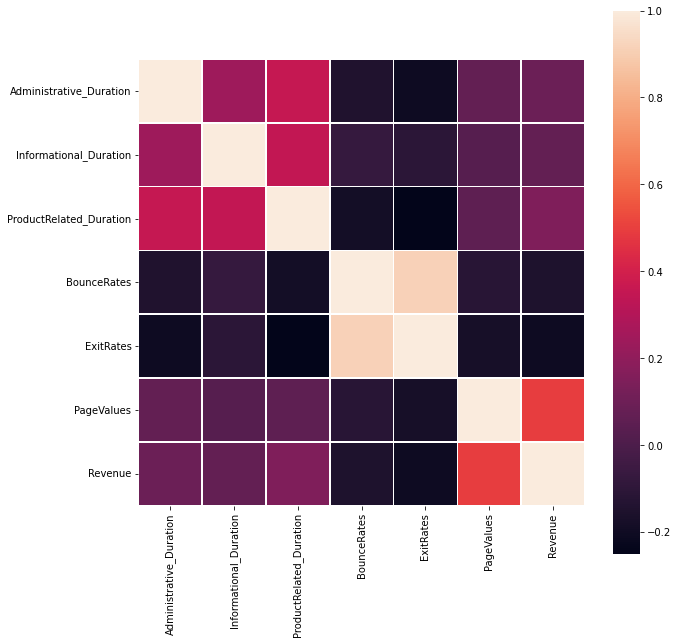

In [ ]:
## Correlation between continuous variables

# plotting area
plt.figure(figsize = (10,10))

# Correlation Matrix 
sns.heatmap(dataset[ ['Administrative_Duration',
                     'Informational_Duration',  
                     'ProductRelated_Duration',
                     'BounceRates', 
                     'ExitRates', 
                     'PageValues',
                     'Revenue']].corr(), vmax = 1., square = True, linewidths=.5)

* We noticed the negative correlation between Bounce and Revenue, and ExitRates and Revenue, which was already expected, since the less time the user spends on the site, we imagine that the lower the probability of purchase.

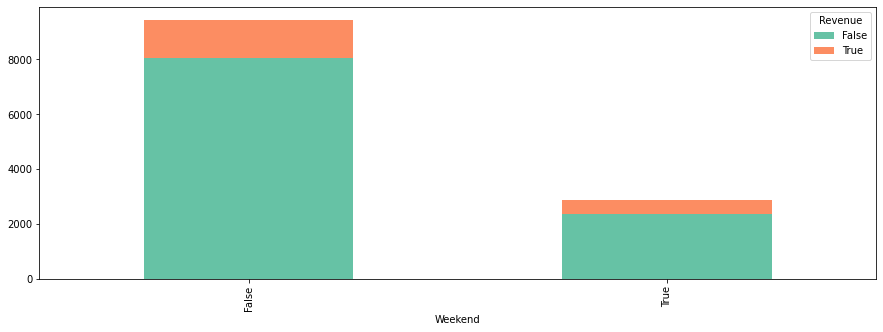

In [ ]:
# Stacked Bar Weekend x Revenue
colors = sns.color_palette("Set2", 2)
pd.crosstab(dataset['Weekend'], dataset['Revenue']).plot(kind = 'bar', 
                                                         stacked = True, 
                                                         figsize = (15, 5), 
                                                         color = colors)

*   Notamos que a maior parte das vendas é realizada fora dos finais de semana (parte laranja do gráfico a direita)

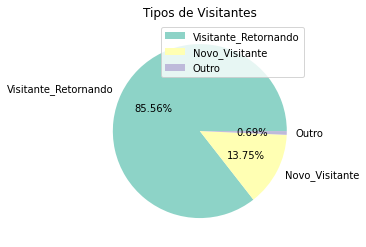

In [ ]:
# Pie Chart Types of Visitors
colors = sns.color_palette("Set3", 3)
labels = ['Visitante_Retornando', 'Novo_Visitante', 'Outro']
plt.title("Tipos de Visitantes")
plt.pie(dataset['VisitorType'].value_counts(), labels = labels, autopct = '%.2f%%', colors= colors)
plt.legend()

* We also note that the majority of visitors are return visitors.

## **Pré-processamento - Parte 2**
## Preprocessing - Part 1

In [ ]:
# Transforming some categorical variables into numerical ones
dataset = preprocessor.encoder(dataset, vars = ['Month','VisitorType'])
dataset.head()

0 instâncias foram removidas.


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,2,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,2,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,2,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,2,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,2,True,False


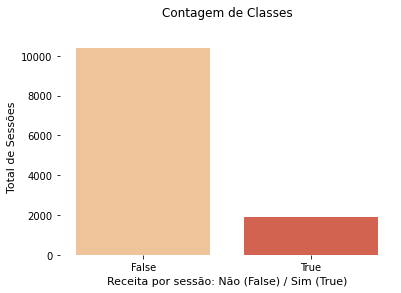

In [ ]:
# Checking if the class variable is balanced
sns.countplot(dataset.Revenue, palette = "OrRd")
plt.box(False)
plt.xlabel('Receita por sessão: Não (False) / Sim (True)', fontsize = 11)
plt.ylabel('Total de Sessões', fontsize = 11)
plt.title('Contagem de Classes\n')
plt.show()

* Note that there is an imbalance between buyer and non-buyer user classes. In order not to reduce the number of samples, we decided to use the oversample method, from the SMOTE function of the imblearn.over_sampling package

<class 'pandas.core.frame.DataFrame'>
Numero de linhas no conjunto X: 20816
Numero de cokunas no conjunto X: 17
Numero de linhas no conjunto y: 20816


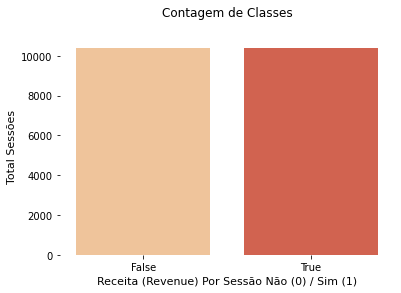

In [ ]:
# Balancing the classes
X, y = preprocessor.balance_classes(dataset)
# Plotting the new result of class balancing
sns.countplot(y, palette = "OrRd")
plt.box(False)
plt.xlabel('Receita (Revenue) Por Sessão Não (0) / Sim (1)', fontsize = 11)
plt.ylabel('Total Sessões', fontsize = 11)
plt.title('Contagem de Classes\n')
plt.show()

In [ ]:
# Split into Training and Test Data.
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.3, random_state = 42)
# Re-scrambling the data
sc = StandardScaler()
X_treino_scaled = sc.fit_transform(X_treino)
X_teste_scaled = sc.transform(X_teste)

## **Modelo de Classificação**
## Classification Model


In [ ]:
# Initializing the MLModel and MlEvaluator classes
mlmodel = MLModel() 
evaluator = MlEvaluator()

### **SVM - Kernel Linear**
### SVM - Linear Kernel

In [ ]:
# Executando o modelo svm linear 
# dados não reescalados: V2
modelo_v1 = mlmodel.trainLinearSVM(X_treino, y_treino)
# Avaliando o modelo v1
evaluator_v1 = evaluator.evaluate_accuracy(model_v1, X_teste_scaled, y_teste, 
                              kernel = 'Linear', algorithm = 'SVM',
                              version = '1')

Tempo de Treinamento do Modelo: 6743.027759075165


ic| dict_previsions: {'AUC': 0.5729798918522366,
                      'Acurácia': 0.5727782225780624,
                      'F1 Score': 0.567304573467402,
                      'Kernel': 'Linear',
                      'Modelo': 'SVM',
                      'Precision': 0.5541825095057035,
                      'Recall': 0.5810631229235881,
                      'Versão': '1'}


In [ ]:
# Executando o modelo svm linear 
# dados reescalados: V2
modelo_v2 = mlmodel.trainLinearSVM(X_treino_scaled, y_treino)
evaluator_v2 = evaluator.evaluate_accuracy(model_v2, X_teste_scaled, y_teste, 
                              kernel = 'Linear', algorithm = 'SVM',
                              version = '2')

Tempo de Treinamento do Modelo: 9.809322357177734


ic| dict_previsions: {'AUC': 0.8452763926619704,
                      'Acurácia': 0.844675740592474,
                      'F1 Score': 0.8370295698924732,
                      'Kernel': 'Linear',
                      'Modelo': 'SVM',
                      'Precision': 0.7892902408111534,
                      'Recall': 0.8909155937052933,
                      'Versão': '2'}


### **SVM - Kernel RBF e Hiperparâmetros com Grid Search**
### SVM - Kernel RBF and Hyperparameters with Grid Search

In [ ]:
# Running the svm model with RBF kernel and grid search
# rescaled data: V3
model_v3 = mlmodel.trainRbfGridSVM(X_treino_scaled, y_treino)
evaluator_v3 = evaluator.evaluate_accuracy(model_v3, X_teste_scaled, y_teste, 
                              kernel = 'RBF', algorithm = 'SVM',
                              version = '3')

Tempo de Treinamento do Modelo com Grid Search: 146.93501234054565
Acurácia em Treinamento: 87.41%

Hiperparâmetros Ideais: {'C': 200.0, 'gamma': 0.003}


ic| dict_previsions: {'AUC': 0.8684000650741152,
                      'Acurácia': 0.8680544435548438,
                      'F1 Score': 0.8649623074401837,
                      'Kernel': 'RBF',
                      'Modelo': 'SVM',
                      'Precision': 0.8361850443599493,
                      'Recall': 0.8957909029192125,
                      'Versão': '3'}


### **SVM - Kernel Polinomial e Hiperparâmetros com Grid Search**
### SVM - Kernel Polynomial and Hyperparameters with Grid Search

In [ ]:
# Running svm model with polynomial kernel and grid search
# rescaled data: V4
model_v4 = mlmodel.trainPoliGridSVM(X_treino_scaled, y_treino)
evaluator_v4 = evaluator.evaluate_accuracy(model_v4, X_teste_scaled, y_teste, 
                              kernel = 'Polinomial', algorithm = 'SVM',
                              version = '4')

Tempo de Treinamento do Modelo com Grid Search: 124.74637007713318
Acurácia em Treinamento: 86.14%

Hiperparâmetros Ideais: {'coef0': 1.0, 'degree': 4, 'gamma': 0.01}


ic| dict_previsions: {'AUC': 0.8547442968856743,
                      'Acurácia': 0.8542834267413931,
                      'F1 Score': 0.8491879350348028,
                      'Kernel': 'Polinomial',
                      'Modelo': 'SVM',
                      'Precision': 0.811787072243346,
                      'Recall': 0.8902015288394719,
                      'Versão': '4'}


### **Random Forest Classifier**

In [ ]:
# Instantiating the model with 1000 decision trees
model_v5 = mlmodel.trainRandonForestCl(X_treino_scaled, y_treino, estimators=1000)
# Using random forest on test set
evaluator_v5 = evaluator.evaluate_accuracy(model_v5, X_teste_scaled, y_teste, 
                                           version = '5', algorithm = "RF")

Numero de estimadores: 1000
Tempo de Treinamento do Modelo: 27.751112461090088


ic| dict_previsions: {'AUC': 0.9275522716241161,
                      'Acurácia': 0.9277822257806245,
                      'F1 Score': 0.9299798167986337,
                      'Kernel': 'NO',
                      'Modelo': 'RF',
                      'Precision': 0.9489860583016476,
                      'Recall': 0.9117199391171994,
                      'Versão': '5'}


### **LightGBM Classifier**

In [ ]:
# Instantiating the LGBM model
model_v6 = mlmodel.trainLGBMcl(X_treino_scaled, y_treino)
# Using the model in the test set
evaluator_v6 = evaluator.evaluate_accuracy(model_v6, X_teste_scaled, y_teste, 
                                           version = '6', algorithm = "LGBM")

ic| dict_previsions: {'AUC': 0.9291911771644835,
                      'Acurácia': 0.9292233787029623,
                      'F1 Score': 0.9301296237748972,
                      'Kernel': 'NO',
                      'Modelo': 'LGBM',
                      'Precision': 0.9321926489226869,
                      '

Tempo de Treinamento do Modelo: 0.3331410884857178


Recall': 0.9280757097791799,
                      'Versão': '6'}


### **Adaa Boost Classifier**

In [ ]:
# Instantiating the model with 1000 estimators
model_v7 = mlmodel.adaboostCl(X_treino_scaled, y_treino, estimators=1000)

#P redict the response for test dataset
evaluator_v7 = evaluator.evaluate_accuracy(model_v7, X_teste_scaled, y_teste, 
                                           version = '7', algorithm = "AdaBoost")

Numero de estimadores: 1000
Taxa de aprendizado: 1
Tempo de Treinamento do Modelo: 19.988719940185547


ic| dict_previsions: {'AUC': 0.9221309844285767,
                      'Acurácia': 0.922177742193755,
                      'F1 Score': 0.9232712346068834,
                      'Kernel': 'NO',
                      'Modelo': 'AdaBoost',
                      'Precision': 0.926489226869455,
                      'Recall': 0.920075519194462,
                      'Versão': '7'}


### **Benchmark**

In [ ]:
# Concatenates all ratings into a pandas dataframe
benchmark = pd.DataFrame({'Execution_1':pd.Series(evaluator_v1),
                          'Execution_2':pd.Series(evaluator_v2),
                          'Execution_3':pd.Series(evaluator_v3),
                          'Execution_4':pd.Series(evaluator_v4),
                          'Execution_5':pd.Series(evaluator_v5),
                          'Execution_6':pd.Series(evaluator_v6),
                          'Execution_7':pd.Series(evaluator_v7)
                          })
benchmark.T.sort_values(by='Acurácia', ascending= False)

,AUC,Acurácia,F1 Score,Kernel,Modelo,Precision,Recall,Versão
Execution_6,0.929191,0.929223,0.93013,NO,LGBM,0.932193,0.928076,6
Execution_5,0.927552,0.927782,0.92998,NO,RF,0.948986,0.91172,5
Execution_7,0.922131,0.922178,0.923271,NO,AdaBoost,0.926489,0.920076,7
Execution_3,0.8684,0.868054,0.864962,RBF,SVM,0.836185,0.895791,3
Execution_4,0.854744,0.854283,0.849188,Polinomial,SVM,0.811787,0.890202,4
Execution_2,0.845276,0.844676,0.83703,Linear,SVM,0.78929,0.890916,2
Execution_1,0.57298,0.572778,0.567305,Linear,SVM,0.554183,0.581063,1


* Due to the execution time, the initial tests were made from the 70-30 split, training and testing respectively.

* Comparison of Benckmark versions 1 and 2, SVM algorithm with Linear kernel, showed that data rescaled by the StandardScaler() function returned better accuracy when compared to data without pre-processing.

* The LighGBM algorithm, run from the data rescaled by the StandardScaler() function, demonstrated better F1 Score, Recall, Accuracy and AUC considering the test against 6 other different classification models.

* The Random Forest algorithm, executed from the data rescaled by the StandardScaler() function, recorded better precision than the other comparative tests.

* For a better evaluation, we will select the most outstanding models in the last benchmark for a new evaluation, this time through cross-validation.

### **Benchmark - Validação Cruzada**
### Benchmark - Cross Validation



In [ ]:
# Selecionando os 3 melhores modelos para validação cruzada
models = []
models.append(('LGBM', model_v6))
models.append(('RF', model_v5)) 
models.append(('AdaBoost', model_v7))
results = evaluator.cross_validationCl(models)

LGBM: 0.932469 (0.006765)
RF: 0.929517 (0.006774)
AdaBoost: 0.923684 (0.008333)


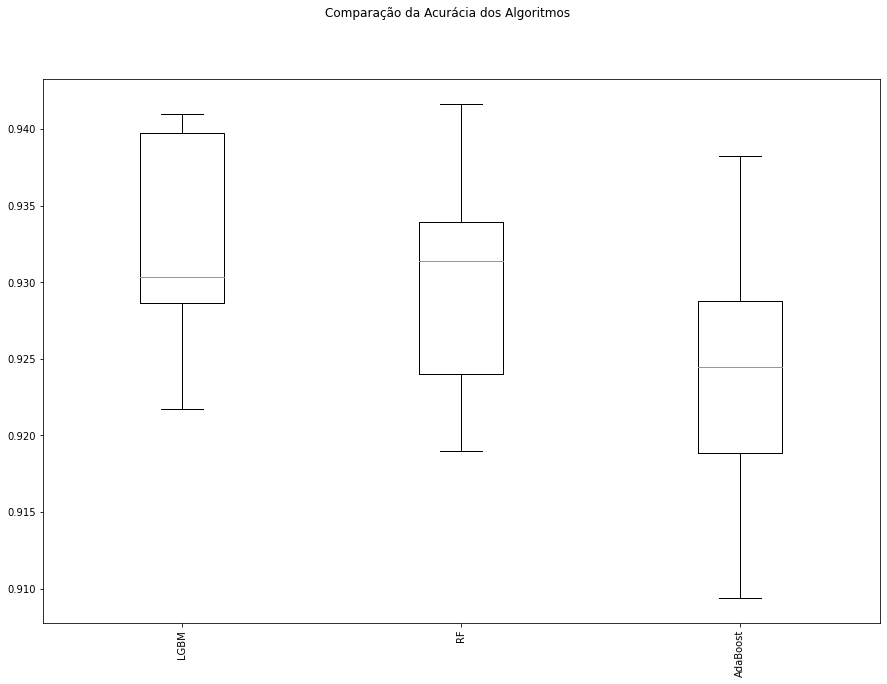

In [ ]:
# boxplot de comparação dos algoritmos
fig = plt.figure(figsize=(15,10)) 
fig.suptitle('Comparação da Acurácia dos Algoritmos') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names) 
plt.xticks(rotation=90)
plt.show()

* Boxplot above shows the strength of the LighGBM model when compared to the Random Forest and AdaBoost models. The results of the first and second quartiles are clearly superior to those of the other models. On average, the results of the random forest algorithm and lgbm are very similar, with a small difference in performance for lgbm.

## **Fazendo Previsões de novos dados a partir do melhor modelo identificado**
## Making Predictions from new data from the best identified model

### **Selecionando um novo usuário para identificação de propensão de compra**
### Selecting a new user to identify purchase propensity

In [ ]:
# new data entry
user_jorunay_01 = np.array([4.0, 5.56, 1.0, 3.78, 2.995, 6.00, 0.69, 0.70, 0.69, 0, 6, 1, 1, 3, 3, 2, False]).reshape(1, -1)
new_user = pd.DataFrame(user_jorunay_01)
new_user.columns = dataset.columns[:-1]
new_user


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,4.0,5.56,1.0,3.78,2.995,6.0,0.69,0.7,0.69,0.0,6.0,1.0,1.0,3.0,3.0,2.0,0.0


In [ ]:
# Rescaling the new record
user_jorunay_01_scaled = StandardScaler().fit_transform(user_jorunay_01)

# Prevision
prevision_user_jorunay_01 = model_v6.predict(user_jorunay_01_scaled)
# Writing the forecast value
pd.DataFrame(prevision_user_jorunay_01)

,0
0,True


### **Conclusão**
### Conclusion

* **Based on the New User Journey, we can predict with 93.24% accuracy that this user is likely to purchase from this e-commerce.**

* **Users with a purchase forecast identified by the algorithm can be forwarded to google analitycs to send targeted advertising containing discounts on the product offered to enhance customer loyalty.**